In [1]:
import sys
import os

repository_root_directory = os.path.dirname(os.getcwd())
rrd = "repository_root_directory:\t"
print(rrd, repository_root_directory)

if repository_root_directory not in sys.path:
    sys.path.append(repository_root_directory)
    print(rrd, "added to path")
else:  
    print(rrd, "already in path")

import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers.legacy import Adam

repository_root_directory:	 /teamspace/studios/this_studio/csc_461_fp
repository_root_directory:	 added to path


2024-12-11 02:48:31.989595: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

data = np.load(os.path.join(repository_root_directory, "_03_extracted_features_cnn.npz"))

features = data["data"]
labels = data["labels"]

print(features.shape)
print(labels.shape)

(13990, 150, 150, 1)
(13990,)


In [3]:
labels = to_categorical(labels, num_classes = 10) # Converting labels to one-hot encoding
print(labels.shape)
print(labels)

(13990, 10)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [4]:
# Splitting of Dataset into Training and Test set
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(11192, 150, 150, 1)
(2798, 150, 150, 1)
(11192, 10)
(2798, 10)


In [5]:
# Building the CNN Model
model = tf.keras.models.Sequential()

# Convolutional Block 1
'''Conv2D (32 filters, 3x3, padding=same, ReLU)
Visually, think of 32 small “magnifying glasses” sliding over the input image.
Each filter picks out specific local features—edges, small time-frequency patterns.
This gives you 32 new layers (feature maps) of information.
padding='same' pads the input with zeros around the boarder such that the output spatial dimensions
(width and height) of the output are unchanged by the convolution.
'''
# convl1 = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=X_train[0].shape)
# convl2 = Conv2D(filters=32, kernel_size=3, activation='relu')
# pool1 = MaxPool2D(pool_size=2, strides=2)
# model.add(convl1, convl2, pool1)
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=X_train[0].shape))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

# Convolutional Block 2
model.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

# Convolutional Block 3
model.add(Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))
model.add(Dropout(0.3))

# Convolutional Block 4
model.add(Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))

# Convolutional Block 5
model.add(Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
model.add(Conv2D(filters=512,kernel_size=3,activation='relu'))
model.add(MaxPool2D(pool_size=2,strides=2))
model.add(Dropout(0.3))

# Fully Connected Layer
model.add(Flatten())
model.add(Dense(units=1200,activation='relu'))
model.add(Dropout(0.45))

#Output layer
model.add(Dense(units=10, activation='softmax'))

#model.summary()

2024-12-11 02:48:35.250786: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
from tensorflow.keras.optimizers import Adam

# Use the updated optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
#Training Model
training_history = model.fit(X_train,Y_train,epochs=30,batch_size=32,validation_data=(X_test,Y_test))
training_history_data = training_history.history
print(training_history_data)
training_history_data_keys = training_history_data.keys()
print(training_history_data_keys)
model.summary()

Epoch 1/30


350/350 [==============================] - 224s 636ms/step - loss: 1.8874 - accuracy: 0.2780 - val_loss: 1.4944 - val_accuracy: 0.4607
Epoch 2/30
350/350 [==============================] - 215s 614ms/step - loss: 1.4044 - accuracy: 0.4811 - val_loss: 1.2096 - val_accuracy: 0.5790
Epoch 3/30
350/350 [==============================] - 216s 617ms/step - loss: 1.1619 - accuracy: 0.5822 - val_loss: 1.0599 - val_accuracy: 0.6279
Epoch 4/30
350/350 [==============================] - 214s 611ms/step - loss: 0.9615 - accuracy: 0.6603 - val_loss: 0.9193 - val_accuracy: 0.6730
Epoch 5/30
350/350 [==============================] - 212s 605ms/step - loss: 0.8276 - accuracy: 0.7094 - val_loss: 0.8931 - val_accuracy: 0.7162
Epoch 6/30
350/350 [==============================] - 210s 599ms/step - loss: 0.7126 - accuracy: 0.7520 - val_loss: 0.6775 - val_accuracy: 0.7716
Epoch 7/30
350/350 [==============================] - 207s 593ms/step - loss: 0.6433 - accuracy: 0.7806 - val_loss: 0.7139 - val_accura

In [8]:
#Model evaluation on Training set
train_loss, train_accuracy = model.evaluate(X_train,Y_train)
train_loss, train_accuracy

350/350 [==============================] - 20s 58ms/step - loss: 0.0935 - accuracy: 0.9713


(0.09351447224617004, 0.971318781375885)

In [9]:
#Model evaluation on Validation set
val_loss, val_accuracy = model.evaluate(X_test,Y_test)
val_loss, val_accuracy

88/88 [==============================] - 4s 51ms/step - loss: 0.3596 - accuracy: 0.8871


(0.35957521200180054, 0.8870621919631958)

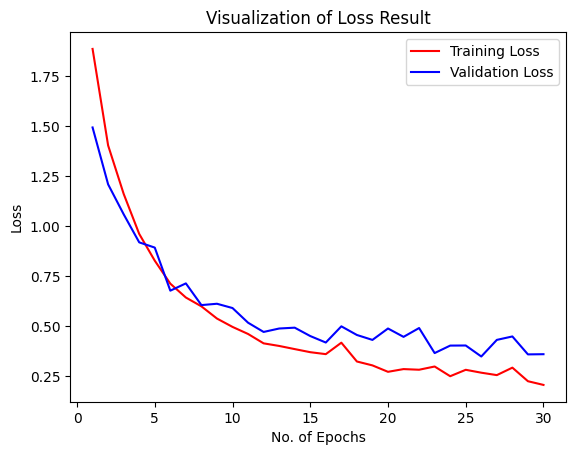

In [10]:
#Visualization of Loss
from matplotlib import pyplot as plt


epochs = [i for i in range(1,31)]
plt.plot(epochs,training_history_data['loss'],label="Training Loss",color='red')
plt.plot(epochs,training_history_data['val_loss'],label="Validation Loss",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Visualization of Loss Result")
plt.legend()
plt.show()

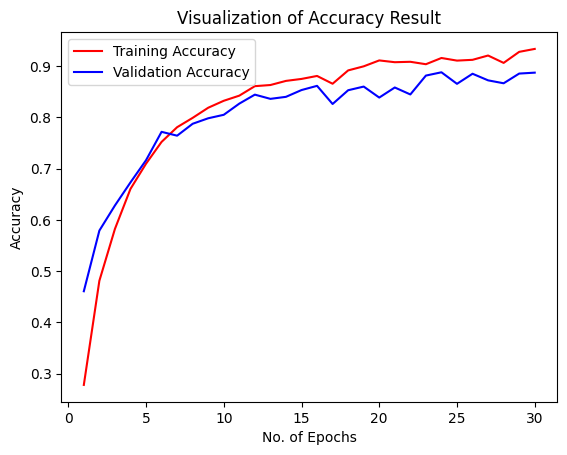

In [11]:
#Visualization of Accuracy
epochs = [i for i in range(1,31)]
plt.plot(epochs,training_history_data['accuracy'],label="Training Accuracy",color='red')
plt.plot(epochs,training_history_data['val_accuracy'],label="Validation Accuracy",color='blue')
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Visualization of Accuracy Result")
plt.legend()
plt.show()

In [13]:
model.save("Trained_model.keras")
model.save("Trained_model.h5") 
